# wpadlab model notebook

This notebook allows the modeling for calibrating weighing pads, as well as generating parameters for the model to use in a component which consumes the weighing pad data.

Documentation for the use is inline with the respective function blocks.

The general principle is: 

* You create a data series using the wpadlab Web frontend and store this. The series consists of arrays of sensor readings and a user-defined target value (e.g. '5' --> this represents 5 crates on the weighing platform).
* The data series is imported.
* The series is plotted.
* You define a general model which can be fitted to the data.
* The model is automatically fitted to the data.
* A second data series is used to check the model predictions.
* You can access current sensor values to do live checking.
* The parameters for the model are exported.


In [1]:
# Define a helper function to call into Wpad procedures via the Crossbar.io REST bridge

#rpc_url = "https://demo.crossbar.io/call"
rpc_url = "http://localhost:8080/call"

import requests, json

def call(proc, *args, **kwargs):
    payload = {
        "procedure": proc,
        "args": args,
        "kwargs": kwargs
    }
    r = requests.post(rpc_url, data=json.dumps(payload),
                      headers={'content-type': 'application/json'})
    res = r.json()
    return res['args'][0]
    

In [2]:
# Get a data series previously stored from the Wpad Lab UI: a dict with keys "A0" - "A6" and "T"
# is returned with arrays of ints with the analog sensors readings (0-1023) and the user defined
# target value (if any was provided)

series = call("io.crossbar.demo.wpad.objstore.get", "series", 4)
series

{u'A0': [1, 1, 4, 0, 1, 1, 1, 0, 1, 1, 3, 0, 0, 1, 1],
 u'A1': [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1],
 u'A2': [1, 2, 1, 1, 1, 1, 0, 0, 1, 0, 3, 0, 1, 1, 1],
 u'A3': [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 0, 1, 1, 1],
 u'A4': [241,
  281,
  288,
  110,
  238,
  286,
  309,
  126,
  256,
  293,
  316,
  132,
  258,
  300,
  305],
 u'A5': [230,
  372,
  443,
  54,
  253,
  376,
  474,
  58,
  274,
  373,
  437,
  58,
  238,
  381,
  440],
 u'A6': [113,
  168,
  201,
  41,
  118,
  160,
  223,
  41,
  115,
  163,
  225,
  45,
  124,
  169,
  200],
 u'T': [1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]}

In [3]:
# Import libs and activate inline plotting

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Define a Wpad data series plotting helper

def plot_series(series):
    fig, ax = plt.subplots()
    ind = np.arange(len(series['T']))
    width, colors = 0.3, ['r', 'b', 'g']
    for i in range(3):
        ax.bar(ind + width * i, series['A{}'.format(i + 4)], width, color=colors[i])

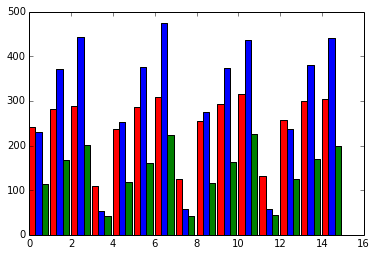

In [5]:
# Plot a Wpad data series: each of the three colors corresponds to one of the analog sensors

plot_series(series)

In [6]:
# Load a second data series

series2 = call("io.crossbar.demo.wpad.objstore.get", "series", 3)
series2

{u'A0': [0, 1, 0, 1, 1, 1, 1, 0],
 u'A1': [0, 1, 3, 1, 0, 1, 0, 1],
 u'A2': [1, 0, 1, 1, 2, 1, 0, 0],
 u'A3': [0, 0, 1, 0, 1, 1, 1, 0],
 u'A4': [100, 184, 248, 282, 285, 259, 225, 131],
 u'A5': [49, 169, 330, 424, 429, 337, 232, 57],
 u'A6': [34, 79, 147, 210, 219, 168, 111, 42],
 u'T': [0, 1, 2, 3, 3, 2, 1, 0]}

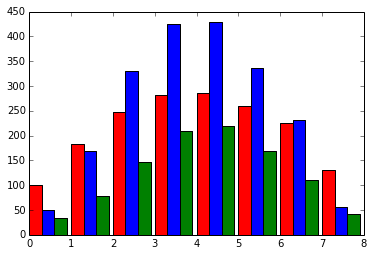

In [7]:
plot_series(series2)

In [8]:
# Fit a logit model to the first data series

from sklearn import linear_model

X = np.matrix([series['A4'], series['A5'], series['A6']]).transpose()
y = series['T']

clf = linear_model.LogisticRegression(C=1.)
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [9]:
# Check prediction error on second data series

from sklearn import metrics

X2 = np.matrix([series2['A4'], series2['A5'], series2['A6']]).transpose()
y2 = series2['T']

pred = clf.predict(X2)
s = metrics.mean_absolute_error(y2, pred)
s

0.125

In [10]:
# Dynamically access current sensor values (A4, A5, A6)

call("io.crossbar.demo.wpad.1.get_last")["values"][4:7]

[169, 77, 49]

In [11]:
# Predict target var based on current sensor values

values = call("io.crossbar.demo.wpad.1.get_last")["values"][4:7]
clf.predict(values)[0]

0

In [12]:
# Here are the model coefficients:

model = [list(row) for row in clf.coef_]
model

[[0.13713643327646236, -0.16962003683960686, -0.012434068567951031],
 [0.047893514375508831, 0.041754192951523814, -0.18341206653266609],
 [-0.015566010423777, 0.13253873142877359, -0.27076483550805064],
 [-0.32054414450499041, 0.13777701913796536, 0.20732446297197651]]

In [13]:
# Upload the model coefficients

call("io.crossbar.demo.wpad.objstore.save", "model", model)

5